In [27]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from environment import State, ManipulatorEnv

np.random.seed(0)

**Task 1: Visualization**

**1A. (10 pts) Visualize the manipulator in the start state and target state. Comment on your thoughts about
comparison the discretized orientation space from PS1 vs continuous orientation space in current problem
set.**

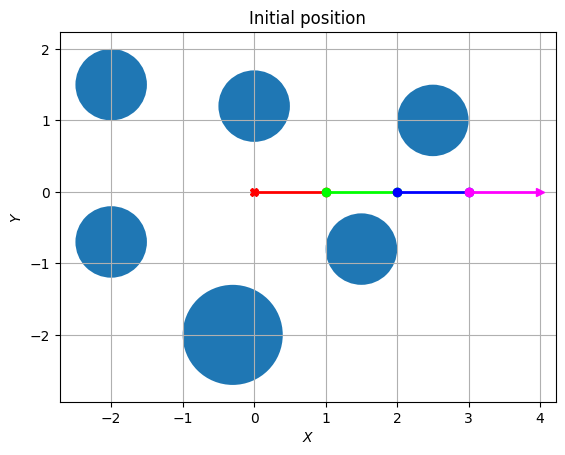

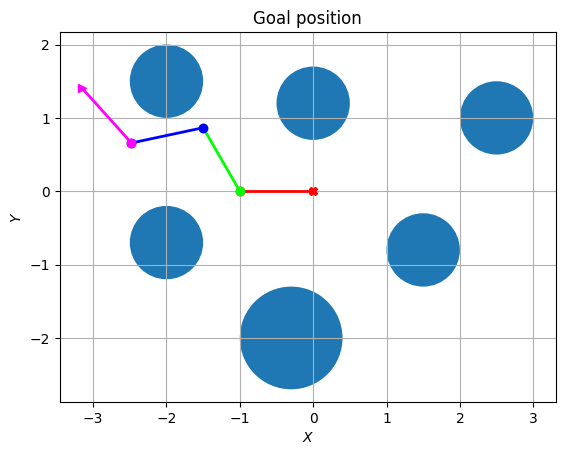

In [28]:
with open("data.pickle", "rb") as handle:
    data = pickle.load(handle)

start_state = State(np.array(data['start_state']))
goal_state = State(np.array(data['goal_state']))

env_start = ManipulatorEnv(obstacles=np.array(data["obstacles"]), initial_state=start_state, collision_threshold=data["collision_threshold"])
env_goal = ManipulatorEnv(obstacles=np.array(data["obstacles"]), initial_state=goal_state, collision_threshold=data["collision_threshold"])

env_start.render('Initial position')
env_goal.render('Goal position')
plt.show()

Discretized configuration space in PS1 consisted of 3 variables [x, y, $\theta$] and had a size of $100*100*4 = 40000$. Here configuration space consists of 4 variables [$\theta_1$, $\theta_2$, $\theta_3$, $\theta_4$] and each angle is discritized from $(-180, 180]$ with 1 degree step, hence we have a size of configuration space here equal to: $360^4$.

**B. (10 pts) Visualize the manipulator in 4 random orientations that include both colliding and non-colliding
configurations. Check what does the ManipulatorEnv.check_collision function returns for those
configurations. Comment on your observations.**

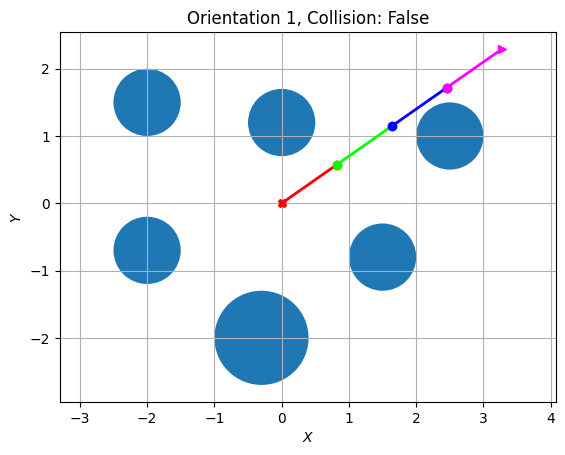

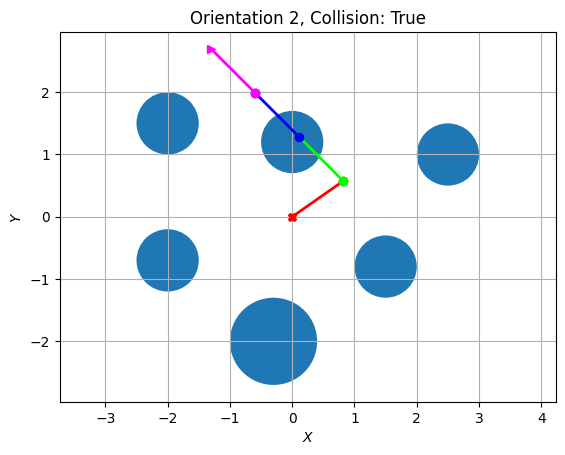

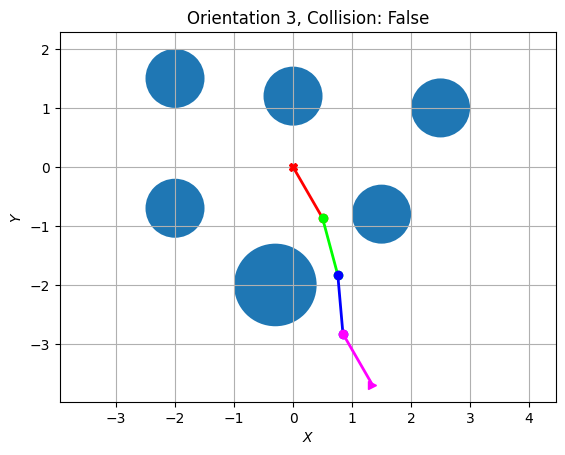

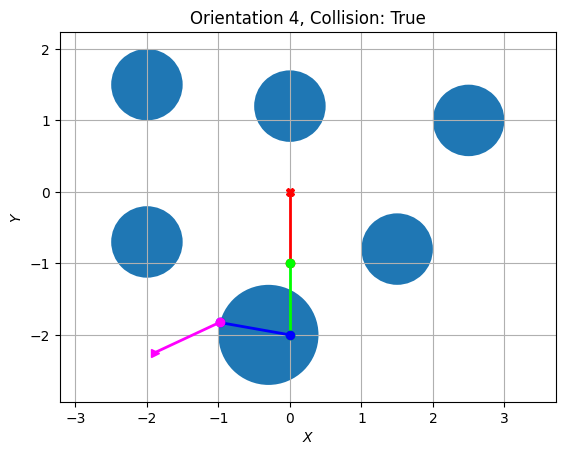

In [29]:
orient = [0, 0, 0, 0]
env_orient = [0, 0, 0, 0]

orient[0] = State(np.array([35, 0, 0, 0]))
orient[1] = State(np.array([35, 100, 0, 0]))
orient[2] = State(np.array([-60, -15, -10, 25]))
orient[3] = State(np.array([-90, 0, -100, 35]))

for i in range(4):
    env_orient[i] = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                                initial_state=orient[i],
                                collision_threshold=data["collision_threshold"])
    
for i in range(4):    
    env_orient[i].render(f'Orientation {i+1}, Collision: {env_start.check_collision(orient[i])}')
plt.show()

Check Collision function returns True when manipulator is in collision with the environment, if not it returns False.

**Task 2A. (40 pts) You need to implement the RRT algorithm for agent in continuous domain. The starting configuration of the agent is (0, 0, 0, 0) and the goal configuration is (-180.0, -60.0, 72.0, -60.0).**

In [30]:
import angle_util

In [31]:
def get_distance(q_1, q_2, weights):
    
    #distance - L1 Manhattan distance between two vectors
    distance = np.linalg.norm(weights * angle_util.angle_difference(q_2, q_1), ord=1)
    
    return distance

def sample(target, weight):

    q_rand = np.random.uniform(-180, 180, 4) + weight * target.angles
    return q_rand

max_difference = 10  # L1 norm

In [37]:
#RRT (Rapidly-exploring Random Trees) Algorithm
def find_path_RRT(start, target, max_difference=max_difference, env=env_start, N = 3000, weights_angles=np.array([1, 1, 1, 1]), target_radius=30):

    parent_table = dict()
    nodes = []
    nodes.append(start)
    flag = False
    plan = 0
    counter = 0

    #RRT Algorithm
    while flag != True:
        if flag == True:
            break
        
        counter += 1
        if counter == N:
            break
        
        q_rand = sample(target, 0.1)
        for i in range(len(q_rand)):
            if q_rand[i] < -180:
                q_rand[i] = 360 - np.abs(q_rand[i])
            elif (q_rand[i] >= 180):
                q_rand[i] = -(360 - q_rand[i])

        distance_to_nodes = dict()
        
        for node in nodes:
            distance_to_nodes[node] = get_distance(q_rand, node.angles, weights=weights_angles)
        nearest_node = min(distance_to_nodes, key=distance_to_nodes.get)
        angle_differences = angle_util.angle_difference(q_rand, nearest_node.angles)
        max_found_deviation = np.max(np.abs(angle_differences))
        n_steps = int(np.ceil(max_found_deviation / max_difference))
        angles_linspace = angle_util.angle_linspace(nearest_node.angles, q_rand, n_steps)
        
        for i in range(1, len(angles_linspace)):
            step_node = State(angles_linspace[i])
            parent_step_node = State(angles_linspace[i - 1])
            collision_flag = env.check_collision(step_node)  # True if collide, False if not collide
            
            if not collision_flag:
                nodes.append(step_node)
                parent_table[tuple(step_node.angles)] = tuple(parent_step_node.angles)
                target_differences = angle_util.angle_difference(target.angles, step_node.angles)
                s = 0
                
                for i in range(len(target_differences)):
                    
                    if np.abs(target_differences[i]) <= target_radius:
                        s += 1
                        
                if s == 4:
                    parent_table[tuple(target.angles)] =  tuple(step_node.angles)
                    flag = True
                    
            else:
                break
        
    if flag:
        print('-------------------------------')
        print('RRT status: Success')

        visited_nodes = len(parent_table)
        print('Amount of visited nodes: ', visited_nodes)

        parent = parent_table[tuple(target.angles)]
        plan = [tuple(target.angles), parent]
        
        while parent != tuple(start.angles):
            if parent == tuple(start.angles):
                break
            
            plan.append(parent_table[parent])
            parent = parent_table[parent]
        
        plan = plan[::-1]

        plan_length = len(plan)
        print('Plan length: ', plan_length)
        print('-------------------------------')
        
    else:
        print('RRT status: Failure')

    return plan

plan = find_path_RRT(start_state, goal_state)

RRT status: Failure


MovieWriter PillowWriter unavailable; using Pillow instead.


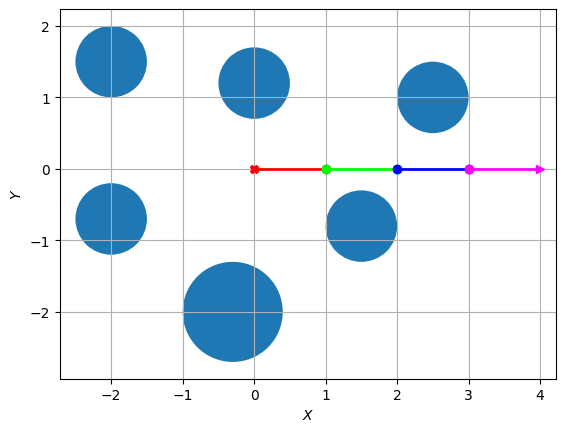

In [33]:
import matplotlib.animation as anim
fig = plt.figure()

def frame(t):
    env_start.state = State(np.array(plan[t])) 
    plt.clf()
    return env_start.render(plt_title=None, plt_show=False)

anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
anime.save("test.gif", writer='PillowWriter', fps=10)

**Task 2B. (10 pts) Comment on how many states have been visited? What is the final trajectory size? Can you
comment on the optimality of the plan? You can also collect some observations and statistics across multiple
runs.**

Average amount of visited states is 3000 nodes. Final trajectory size depends on random seed. But average is around 140. The path is non-optimal, because RRT does not solve this task. RRT* is modification that is responsible for optimal path planning. Average computation time is 50sec, but it depends on random seed.

**Task 2C. (15 pts) Try to change weight of rotation in calculation of distance between two agent positions. We suggest
you to build a distance function based on weighted sum of the angle distances. Comment on the results.**

In [34]:
weights = [0, 0, 0, 0]
weights[0] = np.array([2, 1, 1, 1])
weights[1] = np.array([1, 2, 1, 1])
weights[2] = np.array([1, 1, 2, 1])
weights[3] = np.array([1, 1, 1, 2])


for i in range(len(weights)):
    plan = find_path_RRT(start_state, goal_state, weights_angles=weights[i])
    # Save animation
    if plan != 0:
        fig = plt.figure()
        anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
        anime.save("test_2C.gif", writer='PillowWriter', fps=10)

RRT status: Failure
RRT status: Failure
RRT status: Failure
RRT status: Failure


Increase of weights increased computational time and led to the failure of algorithm

MovieWriter PillowWriter unavailable; using Pillow instead.


-------------------------------
RRT status: Success
Amount of visited nodes:  2230
Plan length:  87
-------------------------------


MovieWriter PillowWriter unavailable; using Pillow instead.


-------------------------------
RRT status: Success
Amount of visited nodes:  1906
Plan length:  90
-------------------------------
RRT status: Failure


MovieWriter PillowWriter unavailable; using Pillow instead.


-------------------------------
RRT status: Success
Amount of visited nodes:  1838
Plan length:  122
-------------------------------


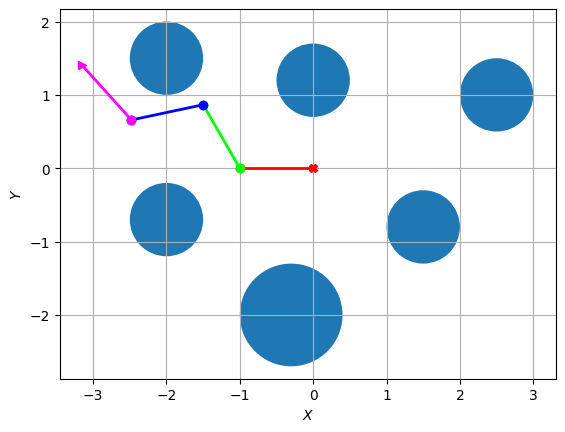

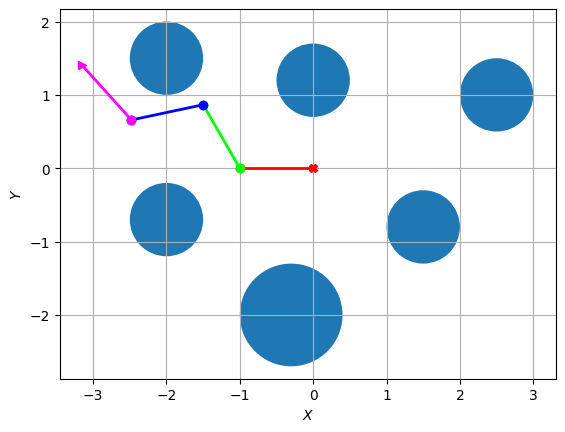

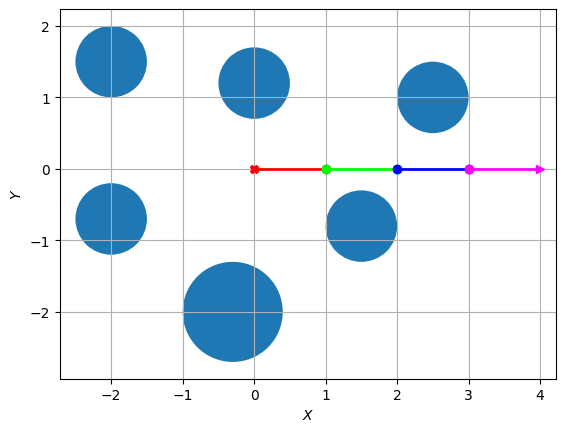

In [35]:
weights = [0, 0, 0, 0]
weights[0] = np.array([0.5, 1, 1, 1])
weights[1] = np.array([1, 0.5, 1, 1])
weights[2] = np.array([1, 1, 0.5, 1])
weights[3] = np.array([1, 1, 1, 0.5])


for i in range(len(weights)):
    plan = find_path_RRT(start_state, goal_state, weights_angles=weights[i])
    # Save animation
    if plan != 0:
        fig = plt.figure()
        anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
        anime.save("test_2C_2.gif", writer='PillowWriter', fps=10)

In [ ]:
Increase of weights extended computational time and led to the algorithm failure in all changing cases

**Task 2D. (15 pts) Try to change step size used for RRT branches. Comment on the results**

In [36]:
# Initialize list of max allowed ranges:
max_diff = [5, 15]

for i in range(len(max_diff)):
    plan = find_path_RRT(start_state, goal_state, max_difference=max_diff[i])
    # Save animation
    if plan != 0:
        fig = plt.figure()
        anime = anim.FuncAnimation(fig, frame, frames=len(plan), blit=False)
        anime.save(f"task2D_{i}.gif", writer='PillowWriter', fps=10)

RRT status: Failure
RRT status: Failure


Change of the max possible angle rotation led to the failure in both cases for random seed 0.

In summary, the RRT algorithm exhibits slowness and lack of stability, affected by various factors, especially the random seed. Despite these challenges, RRT can be used in continuous domains where  algorithms like $A*$ or Dijkstra may not be applicable.